# **Load IMDB Dataset**

## 1. Import Libraries
We import **Pandas** for handling and analyzing tabular data.

## 2. Load Dataset
- Load the IMDB dataset (`IMDB Dataset.csv`) from the given path.  
- The dataset contains **50,000 movie reviews** with their sentiment labels (`positive` or `negative`).  

## 3. Preview Data
- `df.head()` → Shows the first 5 rows of the dataset.  
- `df['sentiment'].value_counts()` → Displays the count of positive and negative reviews in the dataset.  


In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/IMDB Dataset.csv')

# Preview
print(df.head())
print(df['sentiment'].value_counts())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


# **Text Preprocessing**

- **Tokenizer** → Converts reviews into integer sequences.  
- **oov_token="<OOV>"** → Handles unknown words.  
- **pad_sequences** → Pads/truncates all reviews to length = 200.  
- **Final output** = numerical sequences ready for LSTM input.  


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 10000
max_len = 200

# Tokenize reviews
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')


# **Label Encoding**

- Use **LabelEncoder** to convert sentiment labels into numeric form.  
- `positive → 1`, `negative → 0`  
- These encoded labels will be used for training the LSTM model.  


In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df['sentiment'])  # Positive=1, Negative=0


# **Train-Test Split**

- Split data into **training (80%)** and **testing (20%)** sets.  
- `X_train, y_train` → Used for training the model.  
- `X_test, y_test` → Used for evaluating performance.  
- `random_state=42` ensures reproducibility.  


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)


# **Build LSTM Model**

- **Embedding Layer** → Converts words into 64-dimensional vectors.  
- **LSTM Layer (64 units)** → Learns sequential patterns in reviews.  
  - `dropout=0.2` → Prevents overfitting.  
  - `recurrent_dropout=0.2` → Dropout for LSTM connections.  
- **Dense Layer** → Sigmoid activation for binary classification (Positive/Negative).  

**Compilation:**  
- Loss = `binary_crossentropy` (for 2 classes).  
- Optimizer = `adam`.  
- Metric = `accuracy`.  


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# **Train the Model**

- Train the LSTM model using training data.  
- **epochs=5** → Run 5 passes over the dataset.  
- **batch_size=64** → Process 64 samples per update.  
- **validation_data** → Evaluate performance on test set after each epoch.  

The training progress (loss & accuracy) is stored in `history`.  


In [6]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64,
                    validation_data=(X_test, y_test))


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 392ms/step - accuracy: 0.5706 - loss: 0.6620 - val_accuracy: 0.6614 - val_loss: 0.6107
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 392ms/step - accuracy: 0.7041 - loss: 0.5383 - val_accuracy: 0.8820 - val_loss: 0.2932
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 393ms/step - accuracy: 0.8976 - loss: 0.2646 - val_accuracy: 0.8934 - val_loss: 0.2703
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 396ms/step - accuracy: 0.9295 - loss: 0.1995 - val_accuracy: 0.8975 - val_loss: 0.2627
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 395ms/step - accuracy: 0.9093 - loss: 0.2206 - val_accuracy: 0.8936 - val_loss: 0.2807


# **Training Visualization**

## Accuracy Graph
- Plots **Training Accuracy** vs **Validation Accuracy** across epochs.  
- Helps check if the model is learning and generalizing well.  

## Loss Graph
- Plots **Training Loss** vs **Validation Loss** across epochs.  
- Useful for detecting **overfitting** or **underfitting**.  


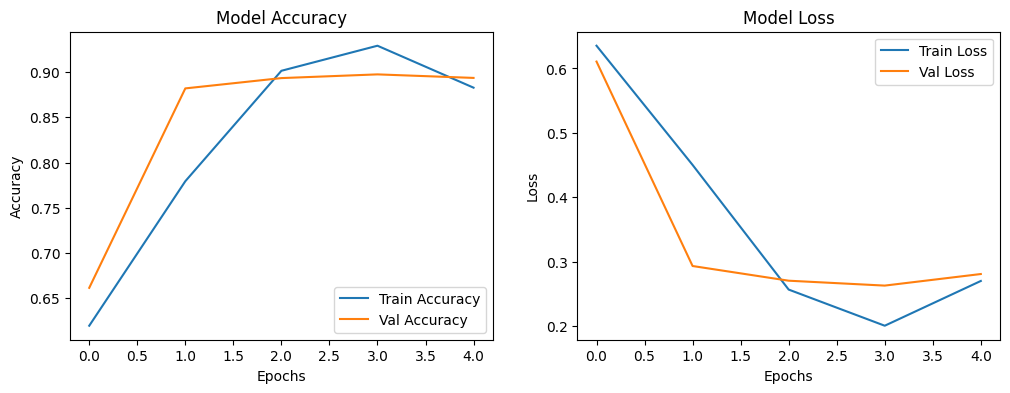

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Accuracy & Loss Graphs
plt.figure(figsize=(12,4))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


# **Model Evaluation**

## Confusion Matrix
- Compares **Actual vs Predicted** labels.  
- Shows how many reviews were correctly or incorrectly classified as **Positive/Negative**.  
- Visualized using a heatmap for clarity.  

## Classification Report
- Displays **Precision, Recall, F1-Score, and Accuracy** for both classes.  
- Helps understand model performance in detail.  


313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step


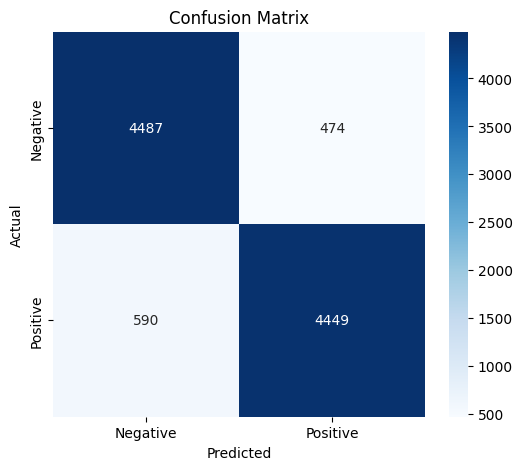

Classification Report:

              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89      4961
    Positive       0.90      0.88      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [9]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


# **Final Model Evaluation**

- `model.evaluate()` → Tests the trained model on unseen **test data**.  
- Returns **loss** and **accuracy**.  
- Final accuracy is printed as a percentage.  


In [10]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {acc:.2%}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.8931 - loss: 0.2812
Final Test Accuracy: 89.36%


# **Prediction Function Explanation**

- **Input text → sequence** using tokenizer.  
- **Pad sequence** to fixed length (`max_len`).  
- **Model predicts probability** (0 → Negative, 1 → Positive).  
- Threshold `0.5`:  
  - > 0.5 → Positive 😀  
  - ≤ 0.5 → Negative 😞  
- Prints review, prediction, and score.  


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


def predict_review(model, tokenizer, text, max_len=200):
    # Convert text to sequence
    seq = tokenizer.texts_to_sequences([text])

    # Pad the sequence
    padded = pad_sequences(seq, maxlen=max_len, padding='post')

    # Get prediction
    pred = model.predict(padded)[0][0]

    # Decide sentiment
    sentiment = "Positive 😀" if pred > 0.5 else "Negative 😞"

    # Print result
    print(f"Review: {text}")
    print(f"Prediction: {sentiment} (score={pred:.2f})\n")



predict_review(model, tokenizer, "This movie was fantastic! Loved it, must watch again.")
predict_review(model, tokenizer, "Worst movie ever, waste of time and money.")
predict_review(model, tokenizer, "The story was okay, but the acting was great.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
Review: This movie was fantastic! Loved it, must watch again.
Prediction: Positive 😀 (score=0.96)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Review: Worst movie ever, waste of time and money.
Prediction: Negative 😞 (score=0.02)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Review: The story was okay, but the acting was great.
Prediction: Negative 😞 (score=0.25)

